In [150]:
import math
import random
import numpy as np
from matplotlib import pyplot as plt
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit.library import UnitaryGate, Initialize
from qiskit.quantum_info import Statevector, Operator

# Input:
 Constants epsilon, δ, Λ ∈ (0, 1), and copies of state ρ ∈ C2n×2n .

In [151]:
def generate_vector_state(ev_delta, n):
	if ev_delta > 1:
		raise ValueError("ev_delta must be less than or equal to 1")
	dim = pow(2,n)
	EV = []
	for i in range(dim):
		if sum(EV) <= 1:
			phi_ev = random.uniform(ev_delta, 1-sum(EV))
			if 1-sum(EV)-phi_ev-ev_delta < 0 or i==dim-1:
				phi_ev = 1.0-sum(EV)
			EV.append(phi_ev)
		else:
			EV.append(0.0)
	return EV

In [152]:
# This is problematic because initalizing a mixed density matrix is not trivial. Maybe I will implement it later.
def generate_rho(ev_delta, n):
	if ev_delta > 1:
		raise ValueError("ev_delta must be less than or equal to 1")
	dim = pow(2,n)
	EV = []
	for i in range(dim):
		if sum(EV) <= 1 - ev_delta:
			phi_ev = random.uniform(ev_delta, 1-sum(EV))
			if 1-sum(EV)-phi_ev-ev_delta < 0 or i==dim-1:
				phi_ev = 1.0-sum(EV)
			EV.append(phi_ev)
		else:
			EV.append(0.0)
	EV = EV
	rho = np.diag(EV)

	Z = np.random.randn(dim, dim) + 1j*np.random.randn(dim, dim)
	R, _ = np.linalg.qr(Z)

	rho = R @ rho @ R.conj().T
	return rho

In [153]:
epsilon = 0.2
delta = 0.05
ev_delta = 0.1
n = 2
# rho = generate_rho(ev_delta, n)
# print(rho)
qstate = generate_vector_state(ev_delta, n)
qstate = Statevector(qstate)


# Algorithm
## Step 1
Compute coefficients L, K, Ml, and b(k)  l as given in Lemma 1.

In [154]:
K = math.ceil(np.log(epsilon*ev_delta)/np.log(1-ev_delta)) # Number of elements in truncated Taylor series
l_part = 0
for i in range(1,K+1):
	l_part += 1/i
l_part = 4 * l_part / epsilon
L = math.log1p(l_part) * 1 / (ev_delta * ev_delta)
M = []
for l in range(math.floor(L)+1):
	Ml = math.ceil(math.sqrt(math.log1p(l_part)*l/2))
	M.append(Ml)

# Calculating blk
def get_B(K, L):
	bkl_matrix = []
	for k in range(1, K + 1):
		bl_array = []
		for l in range(math.floor(L)+1):
			if k == 1:
				if l%2 == 0:
					blk = 0.0
				else:
					blk = 2 * math.comb(l-1,int((l-1)/2))/(math.pi*math.pow(2,l-1)*l)
				bl_array.append(blk)
			else:
				blk = 0.0
				for l_prime in range(l+1):
					blk += bkl_matrix[k-2][l_prime]*bkl_matrix[0][l-l_prime]
				bl_array.append(blk)

		bkl_matrix.append(bl_array)

	return bkl_matrix

B = get_B(K, L)

U = []
for l in range(math.floor(L+1)):
	Ul = min(l,math.ceil(L/2)+M[l])
	U.append(Ul)

D = []
for l in range(math.floor(L+1)):
	Dl = max(0, math.floor(l/2)-M[l])
	D.append(Dl)

def t(s,l):
	return (2*s-l)*math.pi/2

# Variables K, l, M, B, U, D, t

## Step 2
 Compute ‖f ‖l_1 , as given in Eq. (31).

In [155]:
def get_f(s,l):
	k_sum= 0
	for k in range(1,K+1):
		k_sum += B[k-1][l]/k
	return k_sum*math.comb(l,s)/math.pow(2,l)

F = np.array([])
for l in range(math.floor(L)+1):
	for s in range(D[l],U[l]+1):
		f = get_f(s,l)
		F = np.append(F, f)

F_norm = np.linalg.norm(F, ord = 1)
print(F_norm)

3.3676828881440906


## Step 3
Set estimation error ε = epsilon/‖f ‖l_1

In [156]:
error = epsilon/F_norm
print(error)

0.05938801444283811


## Step 4
Set integer N = ∑bLc  l=0(2Ml + 1).

In [157]:
N = 0
for l in range(math.floor(L)-1):
	N += 2*M[l]+1
print(N)

19399


## Step 5
Define a distribution as in Eq. (32).

(0.8741972706749233-1.009994364414758e-17j)


C:\Users\adria\miniconda3\envs\A-Practical-Guide-to-Quantum-Machine-Learning-and-Quantum-Optimization\Lib\site-packages\matplotlib\cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
C:\Users\adria\miniconda3\envs\A-Practical-Guide-to-Quantum-Machine-Learning-and-Quantum-Optimization\Lib\site-packages\numpy\lib\_histograms_impl.py:853: ComplexWarning: Casting complex values to real discards the imaginary part
  indices = f_indices.astype(np.intp)
C:\Users\adria\miniconda3\envs\A-Practical-Guide-to-Quantum-Machine-Learning-and-Quantum-Optimization\Lib\site-packages\numpy\lib\_histograms_impl.py:896: ComplexWarning: Casting complex values to real discards the imaginary part
  db = np.array(np.diff(bin_edges), float)
C:\Users\adria\miniconda3\envs\A-Practical-Guide-to-Quantum-Machine-Learning-and-Quantum-Optimization\Lib\site-packages\matplotlib\axes\_axes.py:7135: ComplexWarning: Casting complex values to real discards the

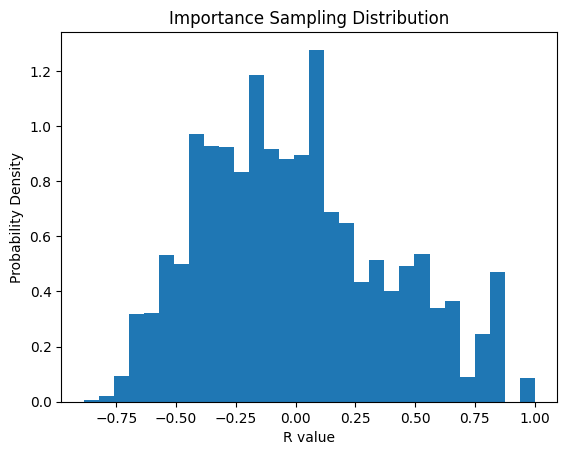

In [158]:
class ImportanceSampling:
	def __init__(self, rho, D, U, F_norm):
		self.samples = []
		current_max = 0
		for l in range(math.floor(L)+1):
			for s in range(D[l],U[l]+1):
				R = np.trace(rho*np.cos(rho*(2*s-l)*math.pi/2))
				prob_density = get_f(s,l)/F_norm
				current_max += prob_density
				pair = [current_max, R]
				self.samples.append(pair)

	def generate_sample(self):
		rand_val = random.uniform(0,1)
		for i in range(len(self.samples)):
			if rand_val <= self.samples[i][0]:
				return self.samples[i][1]

importance_sampler = ImportanceSampling(rho, D, U, F_norm)
sample = importance_sampler.generate_sample()
print(sample)

R_values = [s[1] for s in importance_sampler.samples]

plt.hist(R_values, bins=30, density=True)
plt.xlabel("R value")
plt.ylabel("Probability Density")
plt.title("Importance Sampling Distribution")
plt.show()

## Step 6
Set integer B = #Samples as in Eq. (34).

In [159]:
B_n_samples = round((F_norm/epsilon)**2*np.log(2/delta))
print(f"Required number of samples: {B_n_samples}")

Required number of samples: 1046


## Step 7
Sample B pairs of (s1, l1), . . ., (sB, lB).

In [160]:
B_samples = []
for b in range(1,B_n_samples+1):
	sample = importance_sampler.generate_sample()
	B_samples.append(sample)
b_samples = np.array(B_samples)

print(B_samples[:5])

[np.complex128(-0.10192645714846546-3.307620823278804e-17j), np.complex128(0.47323702185589794+4.779644381481946e-17j), np.complex128(0.10979692793328273+2.745263316729822e-18j), np.complex128(-0.2758295102416569+9.661014923828952e-18j), np.complex128(-0.2758295102416569+9.661014923828952e-18j)]


## Function for step 10

In [161]:
def get_Q(S,L,j,error):
	Q = math.ceil((2*S[j-1]-L[j-1])**2*math.pi**2/(4*error))
	return Q

## Function for step 12

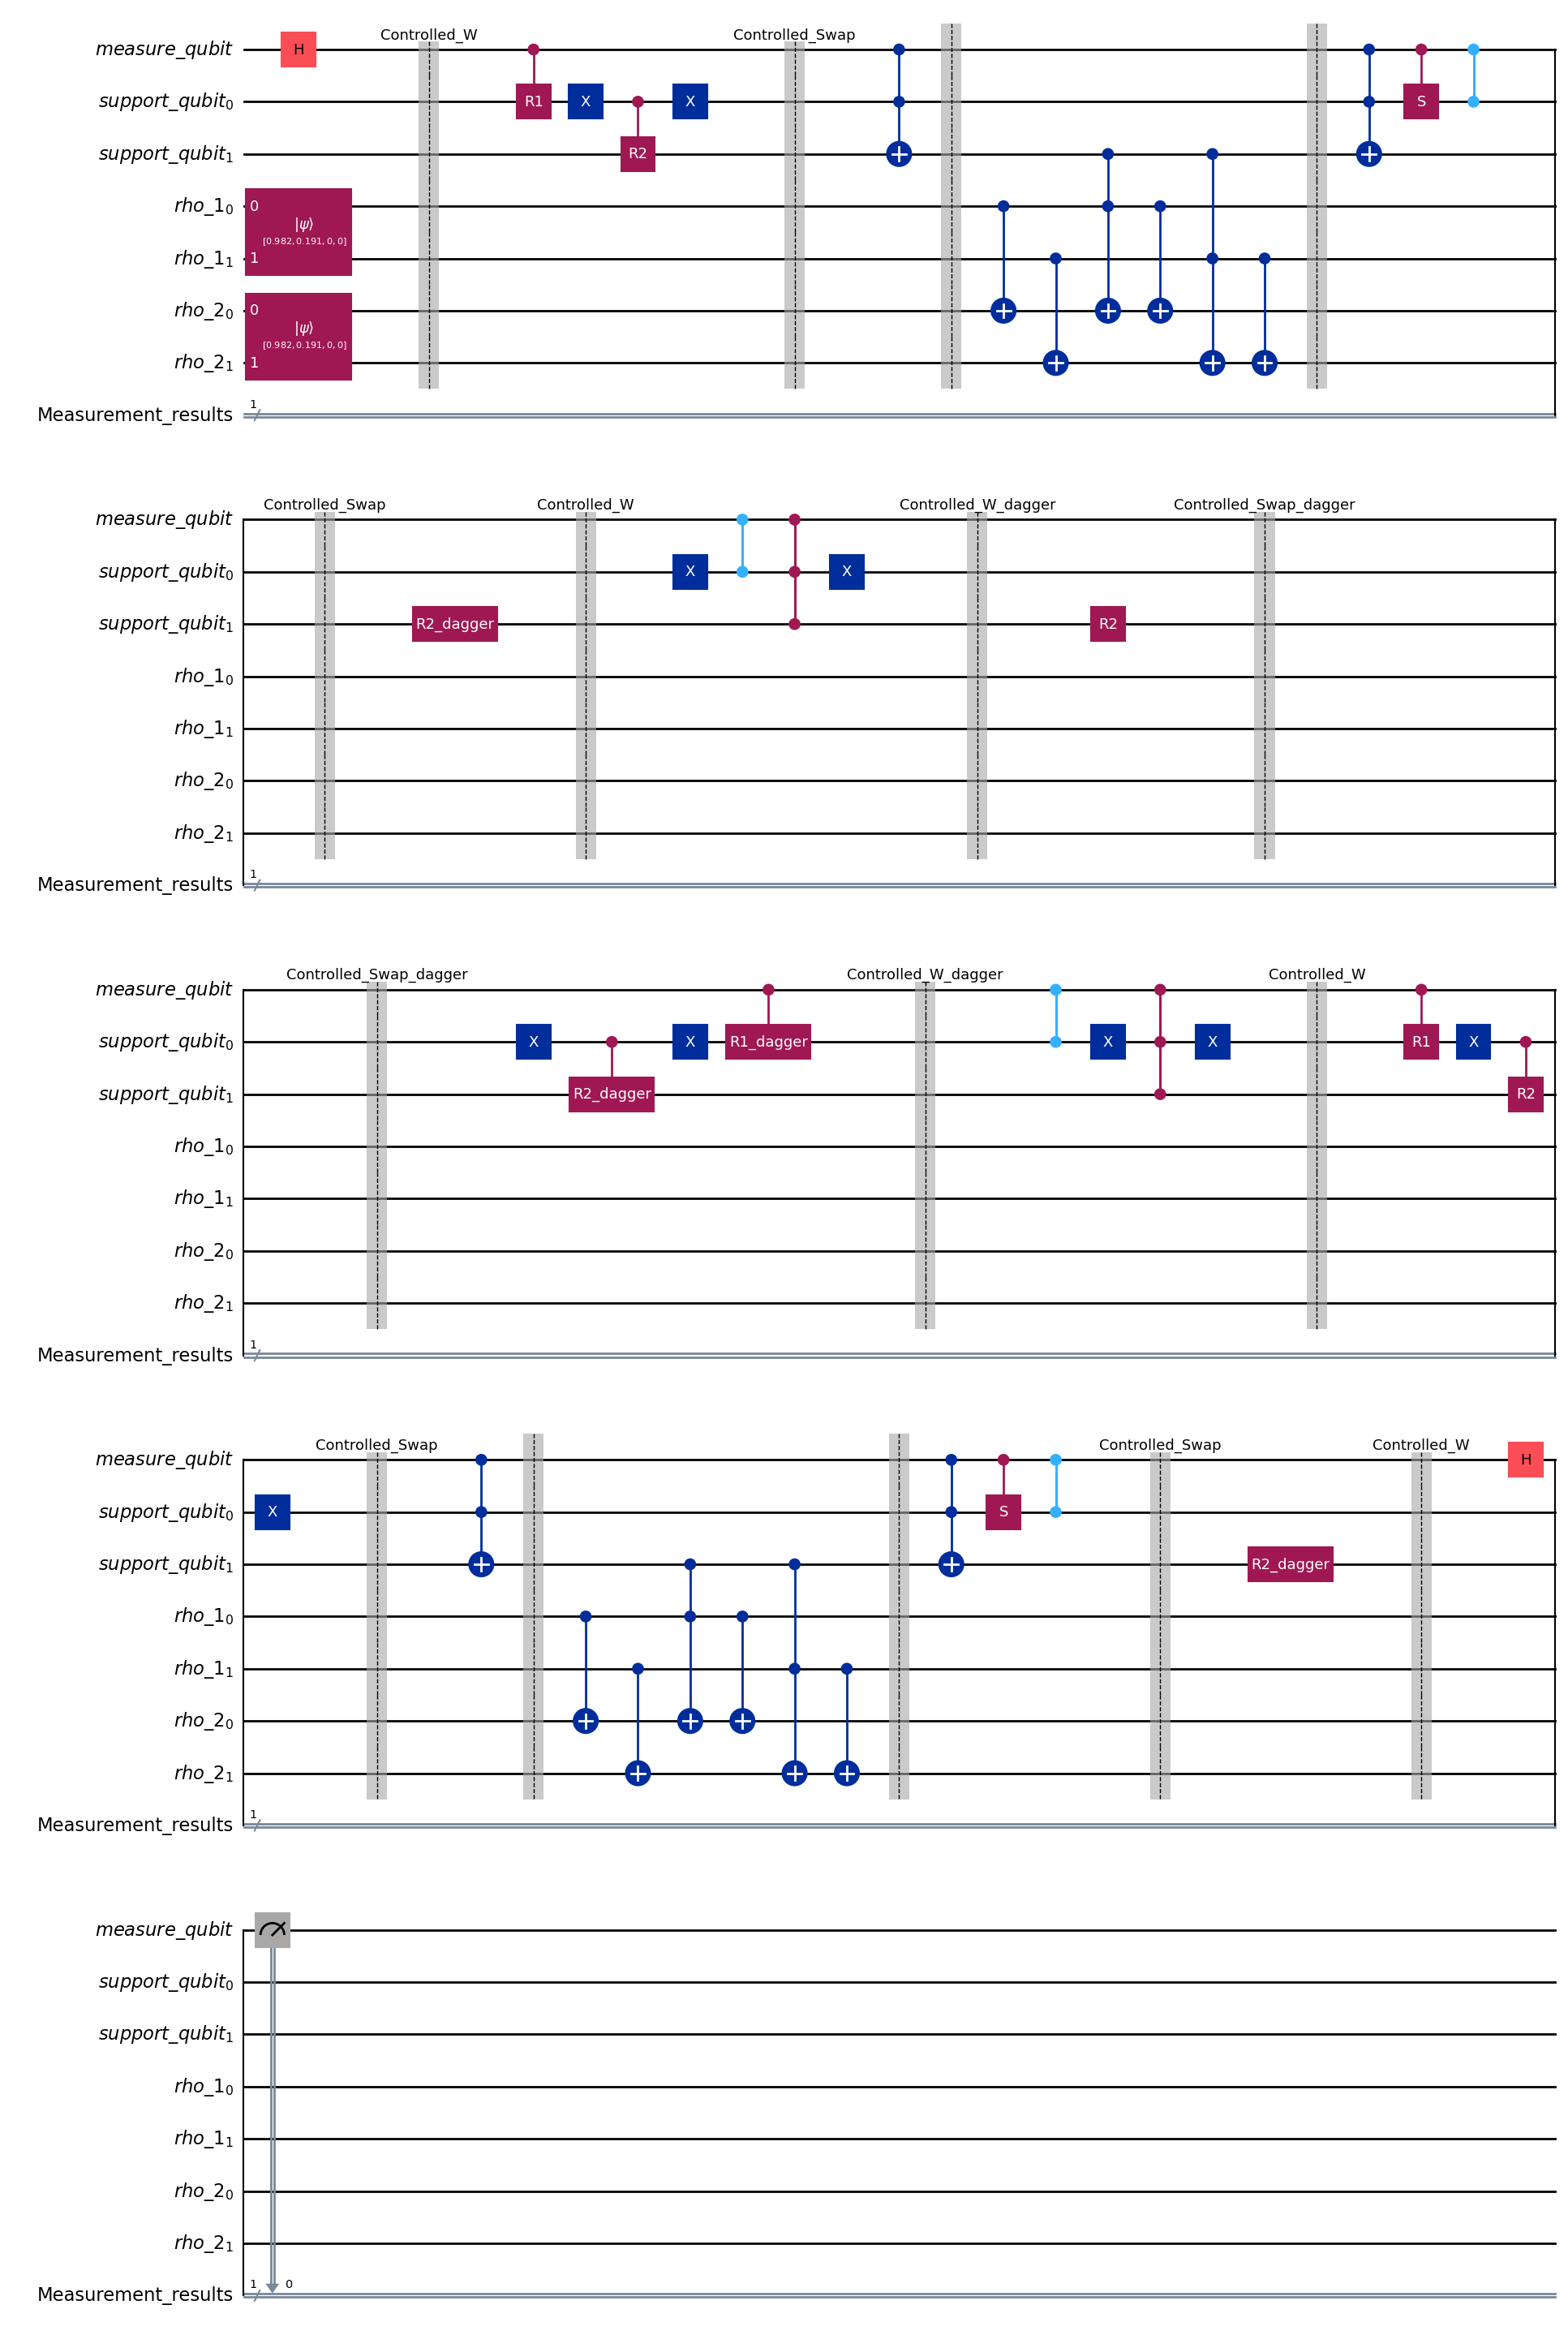

In [165]:
def select_swap(qc, qc_s, qc_m, rho_pair1, rho_pair2, deltat): #TODO dodać odwrotny swap
	qc.ccx(qc_m,qc_s[0],qc_s[1])

	qc.barrier()

	for i in range(rho_pair1.size):
		qc.cx(rho_pair1[i], rho_pair2[i])
		qc.ccx(qc_s[1],rho_pair1[i],rho_pair2[i])
		qc.cx(rho_pair1[i], rho_pair2[i])

	qc.barrier()

	qc.ccx(qc_m,qc_s[0],qc_s[1])
	qc.cs(qc_m,qc_s[0])
	if deltat > 0:
		qc.cz(qc_m,qc_s[0])


def apply_controlled_statevector(qc, control_qbit, target_qbit, statevector, control_state, label="", inverse=False):
	init_gate = Initialize(statevector)
	gate = init_gate.gates_to_uncompute().to_gate()
	if inverse:
		gate = gate.inverse()
	gate.label=label
	c_gate = gate.control()
	if control_state == 1:
		qc.append(c_gate, [control_qbit, target_qbit])
	elif control_state == 0:
		qc.x(control_qbit)
		qc.append(c_gate, [control_qbit,target_qbit])
		qc.x(control_qbit)
	else:
		raise ValueError("control_state must be 0 or 1")

def swap_operation_exponentiation(qc, qc_s, qc_m, rho_copies, deltat, inverse = False):
	alpha = math.cos(deltat)+math.fabs(math.sin(deltat))
	if alpha >=2:
		raise ValueError("alpha must be less than or equal to 2")
	r1 = [alpha/2, math.sqrt(1-alpha**2/4)]
	r2 = [math.sqrt(math.cos(deltat)/alpha), math.sqrt(math.sin(deltat)/alpha)]

	if inverse:
		init_gate = Initialize(r2)
		gate = init_gate.gates_to_uncompute().to_gate()
		gate.label = "R2"
		qc.append(gate, [qc_s[1]])

		qc.barrier(label="Controlled_Swap_dagger")
		# select_swap(qc, qc_s, qc_m, rho_copies, deltat)
		qc.barrier(label="Controlled_Swap_dagger")

		apply_controlled_statevector(qc, qc_s[0], qc_s[1], r2, 0, "R2_dagger", inverse=True)
		apply_controlled_statevector(qc, qc_m, qc_s[0], r1, 1, "R1_dagger", inverse=True)

	else:
		apply_controlled_statevector(qc, qc_m, qc_s[0], r1, 1, "R1")
		apply_controlled_statevector(qc, qc_s[0], qc_s[1], r2, 0, "R2")

		qc.barrier(label="Controlled_Swap")
		rho_pair1 = rho_copies[0]
		rho_pair2 = rho_copies[1]
		select_swap(qc, qc_s, qc_m, rho_pair1, rho_pair2, deltat)
		qc.barrier(label="Controlled_Swap")

		init_gate = Initialize(r2)
		dagger_gate = init_gate.gates_to_uncompute().to_gate().inverse()
		dagger_gate.label = "R2_dagger"
		qc.append(dagger_gate, [qc_s[1]])

def quantum_circuit(qstate, Q):
	num_rho_size = qstate.num_qubits

	qc_m = QuantumRegister(1, name="measure_qubit")
	qc_s = QuantumRegister(2, name="support_qubit")

	rho_copies = []
	for i in range(Q+1):
		rho_copies.append(QuantumRegister(num_rho_size, name=f"rho_{i+1}"))

	creq = ClassicalRegister(1, name="Measurement_results")
	qc = QuantumCircuit(qc_m, qc_s, *rho_copies, creq, name="Von_Neumann_Entropy")

	for i in range(Q+1):
		qc.initialize(qstate, rho_copies[i], normalize=True)

	qc.h(qc_m)

	qc.barrier(label="Controlled_W")
	swap_operation_exponentiation(qc, qc_s, qc_m, rho_copies, 0.1)
	qc.barrier(label="Controlled_W")

	qc.x(qc_s[0])
	qc.cz(qc_m,qc_s[0])
	qc.ccz(control_qubit1=qc_m,control_qubit2=qc_s[0],target_qubit=qc_s[1])
	qc.x(qc_s[0])

	qc.barrier(label="Controlled_W_dagger")
	swap_operation_exponentiation(qc, qc_s, qc_m, rho_copies, 0.1, inverse = True)
	qc.barrier(label="Controlled_W_dagger")

	qc.cz(qc_m,qc_s[0])
	qc.x(qc_s[0])
	qc.ccz(control_qubit1=qc_m,control_qubit2=qc_s[0],target_qubit=qc_s[1])
	qc.x(qc_s[0])

	qc.barrier(label="Controlled_W")
	swap_operation_exponentiation(qc, qc_s, qc_m, rho_copies, 0.1)
	qc.barrier(label="Controlled_W")

	qc.h(qc_m)
	qc.measure(qc_m,creq)
	return qc

Q = 1
qc = quantum_circuit(qstate, Q)
qc.draw("mpl")

## Step 8 - 16


In [108]:
pass